# Sales market basket analysis with pyspark and Apriori Algorithm

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from os import sep 
import pyspark 
from time import time 
import seaborn as sns 

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F, SparkSession, Column,types
from pyspark.sql.functions import col,isnan,when,count, split, to_timestamp
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.fpm import FPGrowth,FPGrowthModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer, CountVectorizer
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import lit

plt.style.use('seaborn-v0_8-darkgrid')
import warnings
warnings.filterwarnings('ignore') 

## Create spark session

In [2]:
import subprocess

def check_java_installation():
    try:
        # Run 'java -version' command
        result = subprocess.run(['java', '-version'], capture_output=True, text=True, check=True)
        # Output the result
        print("Java is installed and accessible:")
        print(result.stderr)  # Java version information is output to stderr
    except subprocess.CalledProcessError as e:
        print("Java is not accessible.")
        print(e)
    except FileNotFoundError:
        print("Java is not installed or not found in the system PATH.")

if __name__ == "__main__":
    check_java_installation() 

Java is installed and accessible:
java version "1.8.0_421"
Java(TM) SE Runtime Environment (build 1.8.0_421-b09)
Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)



In [3]:
spark = SparkSession.builder.appName('SalesMarketBasketAnalysis').getOrCreate()
sqlCtx = SQLContext(spark)
spark  

In [4]:
data = spark.read.csv('Sales_Data.csv',header=True,sep=";",inferSchema=True)
data.show(5) 

+------+--------------------+--------+----------------+-----+----------+--------------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|
+------+--------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2,55|     17850|United Kingdom|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2,75|     17850|United Kingdom|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
+------+--------------------+--------+----------------+-----+----------+--------------+
only showing top 5 rows



In [5]:
data.summary().show() 

+-------+------------------+--------------------+------------------+----------------+------------------+------------------+-----------+
|summary|            BillNo|            Itemname|          Quantity|            Date|             Price|        CustomerID|    Country|
+-------+------------------+--------------------+------------------+----------------+------------------+------------------+-----------+
|  count|            522064|              520609|            522064|          522064|            522064|            388023|     522064|
|   mean| 559950.7852856276|                NULL|10.090435272303779|            NULL|15.576812289966394|15316.931710233672|       NULL|
| stddev|13452.750899836992|                NULL|161.11052518229036|            NULL|  72.6216939005565|1721.8469642664234|       NULL|
|    min|            536365|"ASSORTED FLOWER ...|             -9600|01.02.2011 08:23|         -11062,06|             12346|  Australia|
|    25%|          547892.0|                NULL

## Data Preprocessing and Feature Engineering

In [6]:
type(data) 

pyspark.sql.dataframe.DataFrame

In [7]:
print('Number of records: ',data.count()) 

Number of records:  522064


In [8]:
data.printSchema() 

root
 |-- BillNo: string (nullable = true)
 |-- Itemname: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [9]:
data.columns 

['BillNo', 'Itemname', 'Quantity', 'Date', 'Price', 'CustomerID', 'Country']

In [10]:
data.select('CustomerID').distinct().count() 

4298

In [11]:
data.dtypes

[('BillNo', 'string'),
 ('Itemname', 'string'),
 ('Quantity', 'int'),
 ('Date', 'string'),
 ('Price', 'string'),
 ('CustomerID', 'int'),
 ('Country', 'string')]

#### Change Column type

In [12]:
data = data.withColumn('Price', F.regexp_replace('Price',",",".")) 
data = data.withColumn('Price', F.col('Price').cast('float')) 

In [13]:
data = data.withColumn('Quantity', F.col('Quantity').cast('int'))

In [14]:
data.printSchema() 

root
 |-- BillNo: string (nullable = true)
 |-- Itemname: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



#### Checking for null values

In [15]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------+--------+--------+----+-----+----------+-------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|
+------+--------+--------+----+-----+----------+-------+
|     0|    1455|       0|   0|    0|    134041|      0|
+------+--------+--------+----+-----+----------+-------+



In [17]:
data = data.filter((F.col('Price')>0) & (F.col('Quantity')>0)) 

#### Creating new column for Total Price

In [18]:
data = data.withColumn('TotalPrice', F.round(F.col('Price')*F.col('Quantity'),2))
data.show(5) 

+------+--------------------+--------+----------------+-----+----------+--------------+----------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|TotalPrice|
+------+--------------------+--------+----------------+-----+----------+--------------+----------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2.55|     17850|United Kingdom|      15.3|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3.39|     17850|United Kingdom|     20.34|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2.75|     17850|United Kingdom|      22.0|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3.39|     17850|United Kingdom|     20.34|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3.39|     17850|United Kingdom|     20.34|
+------+--------------------+--------+----------------+-----+----------+--------------+----------+
only showing top 5 rows



#### Input 99999 inplace of NaN

In [19]:
data = data.na.fill(value=99999, subset=['CustomerID']) 
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------+--------+--------+----+-----+----------+-------+----------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|TotalPrice|
+------+--------+--------+----+-----+----------+-------+----------+
|     0|       0|       0|   0|    0|         0|      0|         0|
+------+--------+--------+----+-----+----------+-------+----------+



In [20]:
data = data.filter((F.col("Itemname")!='POSTAGE') & (F.col("Itemname")!='DOTCOM POSTAGE') & (F.col("Itemname")!='Adjust bad debt') & (F.col("Itemname")!='Manual'))

In [21]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show() 

+------+--------+--------+----+-----+----------+-------+----------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|TotalPrice|
+------+--------+--------+----+-----+----------+-------+----------+
|     0|       0|       0|   0|    0|         0|      0|         0|
+------+--------+--------+----+-----+----------+-------+----------+



In [22]:
data[['Itemname']].distinct().count() 

4002

In [23]:
data[['Country']].distinct().count() 

30

In [24]:
data[['Country']].distinct().show() 

+--------------+
|       Country|
+--------------+
|        Sweden|
|       Germany|
|        France|
|       Belgium|
|         Italy|
|     Lithuania|
|        Norway|
|         Spain|
|       Iceland|
|        Israel|
|   Switzerland|
|         Japan|
|        Poland|
|      Portugal|
|     Australia|
|       Austria|
|       Bahrain|
|United Kingdom|
|   Netherlands|
|     Singapore|
+--------------+
only showing top 20 rows



### Changing Column Type (Date) 

In [25]:
data = data.withColumn('Time', F.split('Date'," ",0)[1])

In [26]:
data = data.withColumn("Date",F.split("Date"," ",0)[0])
data = data.withColumn("Date", to_date(data["Date"], "dd.MM.yyyy"))

#### Rearranging Columns

In [27]:
data = data.select('BillNo', 'Itemname', 'Quantity', 'Price', 'CustomerID', 'Country','Date', 'Time','TotalPrice')
data.show(5)

+------+--------------------+--------+-----+----------+--------------+----------+-----+----------+
|BillNo|            Itemname|Quantity|Price|CustomerID|       Country|      Date| Time|TotalPrice|
+------+--------------------+--------+-----+----------+--------------+----------+-----+----------+
|536365|WHITE HANGING HEA...|       6| 2.55|     17850|United Kingdom|2010-12-01|08:26|      15.3|
|536365| WHITE METAL LANTERN|       6| 3.39|     17850|United Kingdom|2010-12-01|08:26|     20.34|
|536365|CREAM CUPID HEART...|       8| 2.75|     17850|United Kingdom|2010-12-01|08:26|      22.0|
|536365|KNITTED UNION FLA...|       6| 3.39|     17850|United Kingdom|2010-12-01|08:26|     20.34|
|536365|RED WOOLLY HOTTIE...|       6| 3.39|     17850|United Kingdom|2010-12-01|08:26|     20.34|
+------+--------------------+--------+-----+----------+--------------+----------+-----+----------+
only showing top 5 rows



### Detecting outliers using IQR method

In [28]:
quantiles = data.approxQuantile('TotalPrice', [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]

iqr = q3-q1 

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr  

In [30]:
outliers = data.filter((data.TotalPrice < lower_bound) | (data.TotalPrice > upper_bound))
outliers.show() 

+------+--------------------+--------+-----+----------+--------------+----------+-----+----------+
|BillNo|            Itemname|Quantity|Price|CustomerID|       Country|      Date| Time|TotalPrice|
+------+--------------------+--------+-----+----------+--------------+----------+-----+----------+
|536367|ASSORTED COLOUR B...|      32| 1.69|     13047|United Kingdom|2010-12-01|08:34|     54.08|
|536370|ALARM CLOCK BAKEL...|      24| 3.75|     12583|        France|2010-12-01|08:45|      90.0|
|536370|ALARM CLOCK BAKEL...|      24| 3.75|     12583|        France|2010-12-01|08:45|      90.0|
|536370|ALARM CLOCK BAKEL...|      12| 3.75|     12583|        France|2010-12-01|08:45|      45.0|
|536370|INFLATABLE POLITI...|      48| 0.85|     12583|        France|2010-12-01|08:45|      40.8|
|536370|SET/2 RED RETROSP...|      18| 2.95|     12583|        France|2010-12-01|08:45|      53.1|
|536370|ROUND SNACK BOXES...|      24| 2.95|     12583|        France|2010-12-01|08:45|      70.8|
|536370|  

In [31]:
print("Total outliers ", outliers.count()) 

Total outliers  40891


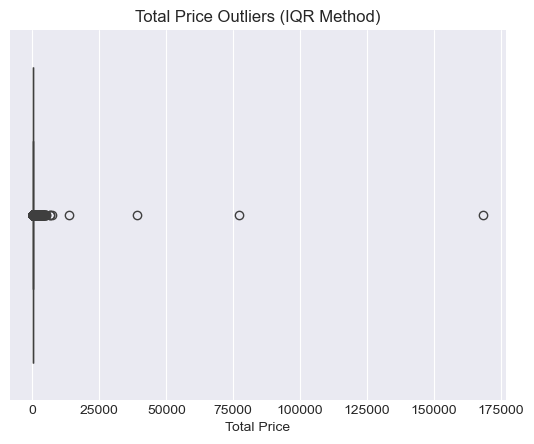

In [33]:
# Convert the outliers_iqr DataFrame to a Pandas DataFrame
outliers_iqr_pd = outliers.select('TotalPrice').toPandas()

# Create a box plot of the outlier values
sns.boxplot(x=outliers_iqr_pd['TotalPrice'], orient='h')

# Set the plot title and axis labels
plt.title('Total Price Outliers (IQR Method)')
plt.xlabel('Total Price')

# Show the plot
plt.show() 

In [34]:
print("The Lower bound of total_price is", lower_bound)
print("THe upper_bound of total_price is", upper_bound) 

The Lower bound of total_price is -16.50000011920929
THe upper_bound of total_price is 36.300000071525574


### Exploratory Data Analysis

In [33]:
data.createOrReplaceTempView("data")

sqlCtx.sql("SHOW TABLES").show()  

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |     data|       true|
+---------+---------+-----------+



In [34]:
total_price_by_country = sqlCtx.sql("""
                                    SELECT Country, ROUND(SUM(TotalPrice), 2) AS Price 
                                    FROM data 
                                    GROUP BY Country
                                    """) 
total_price_by_country.orderBy('Price', ascending=False).show(10)  

+--------------+----------+
|       Country|     Price|
+--------------+----------+
|United Kingdom|8763711.59|
|   Netherlands| 283889.34|
|       Germany| 205569.89|
|        France| 184768.74|
|     Australia| 138171.31|
|         Spain|  55725.11|
|   Switzerland|   53087.9|
|         Japan|  37416.37|
|       Belgium|  36927.34|
|        Sweden|  36839.33|
+--------------+----------+
only showing top 10 rows



In [35]:
top_product_country = sqlCtx.sql("""SELECT Country, Itemname, Quantity FROM
    (SELECT Country, Itemname, Quantity, MAX(Quantity) OVER(PARTITION BY Country) AS Max_Quant FROM data)
    WHERE Quantity=MAX_QUANT
    """)
top_product_country.orderBy('Quantity', ascending=False).show(20, truncate=False)

+--------------+-----------------------------------+--------+
|Country       |Itemname                           |Quantity|
+--------------+-----------------------------------+--------+
|United Kingdom|PAPER CRAFT , LITTLE BIRDIE        |80995   |
|Netherlands   |RABBIT NIGHT LIGHT                 |2400    |
|Japan         |RABBIT NIGHT LIGHT                 |2040    |
|Australia     |MINI PAINT SET VINTAGE             |1152    |
|France        |RABBIT NIGHT LIGHT                 |912     |
|Sweden        |12 PENCILS SMALL TUBE RED RETROSPOT|768     |
|Germany       |ASSORTED COLOURS SILK FAN          |600     |
|Spain         |PINK 3 PIECE POLKADOT CUTLERY SET  |360     |
|Spain         |BLUE 3 PIECE POLKADOT CUTLERY SET  |360     |
|Spain         |CHILDRENS CUTLERY POLKADOT PINK    |360     |
|Spain         |CHILDRENS CUTLERY POLKADOT BLUE    |360     |
|Spain         |CHILDRENS CUTLERY POLKADOT PINK    |360     |
|Austria       |SET 12 KIDS COLOUR  CHALK STICKS   |288     |
|Switzer

In [37]:
expense_per_customer = sqlCtx.sql("""SELECT CustomerID, Country, SUM(TotalPrice) as Price FROM data WHERE CustomerID <> 99999 GROUP BY CustomerID, Country""")
expense_per_customer.orderBy('Price', ascending=False).show(10)

+----------+--------------+------------------+
|CustomerID|       Country|             Price|
+----------+--------------+------------------+
|     14646|   Netherlands| 279138.0201046169|
|     18102|United Kingdom|259657.30027222633|
|     17450|United Kingdom|194550.79052352905|
|     16446|United Kingdom|168472.49374997616|
|     12415|     Australia|124564.53000074625|
|     17511|United Kingdom| 91062.38004624844|
|     12346|United Kingdom|       77183.59375|
|     16029|United Kingdom| 72882.09001159668|
|     16684|United Kingdom| 66653.56011009216|
|     13694|United Kingdom| 65039.61996245384|
+----------+--------------+------------------+
only showing top 10 rows



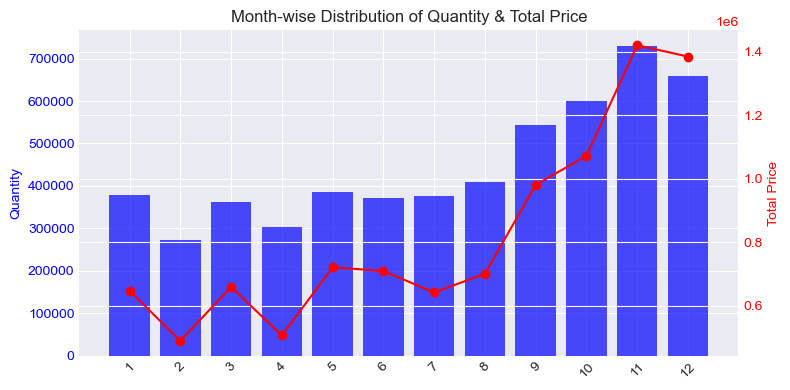

In [38]:
monthly_data = data.groupBy(F.month("Date").alias("Month")) \
    .agg(F.sum("Quantity").alias("TotalQuantity"), F.sum("TotalPrice").alias("TotalPrice")) \
    .orderBy("Month")

pandas_df = monthly_data.toPandas()

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.bar(pandas_df.index, pandas_df['TotalQuantity'], color='b', alpha=0.7, label='Quantity')
ax1.set_ylabel('Quantity', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(pandas_df.index, pandas_df['TotalPrice'], color='r', marker='o', label='Total Price')
ax2.set_ylabel('Total Price', color='r')
ax2.tick_params('y', colors='r')

ax1.set_xticks(pandas_df.index)
ax1.set_xticklabels([month for month in pandas_df['Month']], rotation=45)

plt.title('Month-wise Distribution of Quantity & Total Price')
fig.tight_layout()

plt.show()

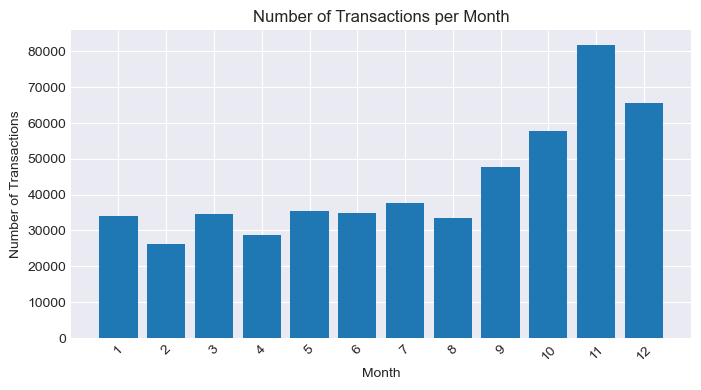

In [39]:
transactions_per_month = data.groupBy(F.month("Date").alias("Month")) \
    .agg(F.count("BillNo").alias("No_Of_Trans"))

transactions_per_month_pd = transactions_per_month.toPandas()
plt.figure(figsize=(8, 4))
plt.bar(transactions_per_month_pd["Month"], transactions_per_month_pd["No_Of_Trans"])
plt.title("Number of Transactions per Month")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(transactions_per_month_pd["Month"], transactions_per_month_pd["Month"], rotation=45)
plt.show()

## Association Rule

In [40]:
indexer = StringIndexer(inputCol="Itemname", outputCol="ItemnameIndex")
data_group = indexer.fit(data).transform(data)
data_group = data_group[['Country', 'BillNo', 'Itemname']].distinct()
data_group = data_group.groupBy('BillNo', 'Country').agg(collect_list('Itemname').alias('Itemname_vec'))
data_group.show()

+------+--------------+--------------------+
|BillNo|       Country|        Itemname_vec|
+------+--------------+--------------------+
|536394|United Kingdom|[FANCY FONT BIRTH...|
|536402|United Kingdom|[HOT WATER BOTTLE...|
|536534|United Kingdom|[HAND WARMER SCOT...|
|536535|United Kingdom|[LOVEBIRD HANGING...|
|536565|United Kingdom|[MIRRORED WALL AR...|
|536575|United Kingdom|[JUMBO BAG RED RE...|
|536611|United Kingdom|[BATHROOM METAL S...|
|536628|United Kingdom|[CREAM CUPID HEAR...|
|536629|United Kingdom|[HAND WARMER RED ...|
|536741|United Kingdom|[6 RIBBONS RUSTIC...|
|536771|United Kingdom|[CLOTHES PEGS RET...|
|536786|United Kingdom|[BAKING SET SPACE...|
|536806|United Kingdom|[TOILET METAL SIG...|
|536832|United Kingdom|[CREAM CUPID HEAR...|
|536838|United Kingdom|[FENG SHUI PILLAR...|
|536841|United Kingdom|[PINK DRAWER KNOB...|
|536944|         Spain|[LUNCH BAG  BLACK...|
|536945|United Kingdom|[TOY TIDY SPACEBO...|
|536972|United Kingdom|[GUMBALL MAGAZINE...|
|536988|Un

In [41]:
countries = []
for country in data[['Country']].distinct().collect():
    countries.append(country['Country']) 

In [42]:
minSupport=0.1
minConfidence=0.8
results = {}

countries = ['Belgium', 'Germany', 'Italy', 'Netherlands', 'Portugal', 'Norway', 'Spain', 'Sweden', 'Australia' ]

for country in countries:
    fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
    model = fpGrowth.fit(data_group.filter(data_group['Country']==country))
    results[country] = model.associationRules

In [43]:
country = countries[0]
apriori = results[country].withColumn('country', lit(country))

for country in countries[1:5]:
    df_temp = results[country].withColumn('country', lit(country))
    apriori =  apriori.union(df_temp)

In [44]:
apriori.createOrReplaceTempView("apriori")
rules = sqlCtx.sql("""SELECT antecedent, consequent, COUNT(DISTINCT country) as n_country , ROUND(AVG(lift), 3) as mean_lift, ROUND(MIN(lift), 3) as min_lift FROM apriori GROUP BY antecedent, consequent""")
rules.sort(col('n_country').desc(), col('mean_lift').desc()).show(10, truncate=False)

+----------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|antecedent                                                      |consequent                           |n_country|mean_lift|min_lift|
+----------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|[ROUND SNACK BOXES SET OF 4 FRUITS]                             |[ROUND SNACK BOXES SET OF4 WOODLAND] |3        |2.896    |2.11    |
|[PLASTERS IN TIN CIRCUS PARADE]                                 |[PLASTERS IN TIN WOODLAND ANIMALS]   |2        |5.595    |5.357   |
|[SET OF 20 KIDS COOKIE CUTTERS, RETROSPOT TEA SET CERAMIC 11 PC]|[GINGERBREAD MAN COOKIE CUTTER]      |1        |8.75     |8.75    |
|[LUNCH BAG CARS BLUE]                                           |[LUNCH BAG WOODLAND]                 |1        |8.75     |8.75    |
|[LUNCH BAG WOODLAND]                                         

In [45]:
minSupport=0.02
minConfidence=0.4

fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
model = fpGrowth.fit(data_group)
results = model.associationRules
results.show(10)

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|[PAPER CHAIN KIT ...|[PAPER CHAIN KIT ...| 0.4768153980752406| 11.40594170488245| 0.02809278350515464|
|[LUNCH BAG CARS B...|[LUNCH BAG  BLACK...| 0.4575971731448763| 7.045543776992539|0.026701030927835052|
|[LUNCH BAG CARS B...|[LUNCH BAG SPACEB...|0.42226148409893993|  7.14199894639881| 0.02463917525773196|
|[LUNCH BAG CARS B...|[LUNCH BAG RED RE...|0.48144876325088337| 6.061068142159076| 0.02809278350515464|
|[LUNCH BAG CARS B...|[LUNCH BAG SUKI D...| 0.4125441696113074| 7.431157744159112|0.024072164948453607|
|[LUNCH BAG CARS B...|[LUNCH BAG PINK P...| 0.4381625441696113| 7.922044135033047| 0.02556701030927835|
|[JUMBO STORAGE BA...|[JUMBO BAG RED RE...| 0.8015564202334631| 

In [46]:
for column in ['confidence', 'lift', 'support']:
    results = results.withColumn(column, round(results[column], 3))

results.sort(col('lift').desc()).show(10, truncate=False)

+------------------------------------------------------------------+-----------------------------------+----------+------+-------+
|antecedent                                                        |consequent                         |confidence|lift  |support|
+------------------------------------------------------------------+-----------------------------------+----------+------+-------+
|[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER]|[PINK REGENCY TEACUP AND SAUCER]   |0.704     |18.585|0.026  |
|[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER] |[GREEN REGENCY TEACUP AND SAUCER]  |0.903     |18.011|0.026  |
|[PINK REGENCY TEACUP AND SAUCER]                                  |[GREEN REGENCY TEACUP AND SAUCER]  |0.822     |16.385|0.031  |
|[GREEN REGENCY TEACUP AND SAUCER]                                 |[PINK REGENCY TEACUP AND SAUCER]   |0.621     |16.385|0.031  |
|[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER] |[ROSES REGENCY 